In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA

## Data Preparation
The data set comes from a local weather station, and it includes hourly observations for
temperature, humidity, and atmospheric pressure. There are approximately six months’ data. For
this project, you will only use the temperatures. Ignore the other two readings. All the class files
are posted in Moodle. Use the one that has your ID.

Partition your data set into two roughly equal parts of contiguous data. The first part is the training
set and the second part is testing set. Use the training set to do tasks 2, 3, and 4. Use the testing set
to do task 5.

In [2]:
# Read dataset and extract temp (1st. column).
def read_data():
    df = pd.read_csv('./data/200263453.csv')
    df = df.iloc[:,:1]
    df = df.rename(columns = {'2m Temperature (hr. avg) (F)': 'Temperature'})
    return df

data = read_data()
data.describe()

,Temperature
count,4345.000000
mean,57.343014
std,16.497043
min,15.100000
25%,43.700000
50%,59.500000
75%,69.600000
max,93.400000


## Task 1. Check for stationarity
Plot the entire time series (i.e. both training and testing sets) and check it visually for stationarity.
If it is not stationary, make appropriate transformations as discussed in section 6.1.2 of the book.
Comment on your conclusions.

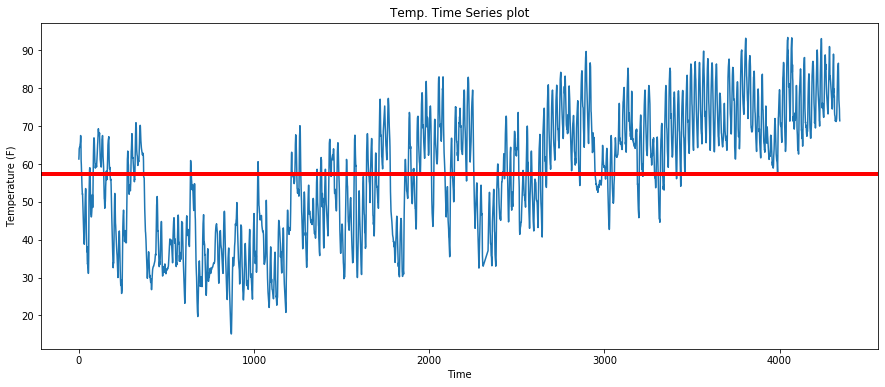

In [31]:
def plot_timeseries(data, title):
    mean = np.mean(data)
    plt.figure(figsize=(15,6))
    plt.plot(data)
    plt.axhline(y=mean,linewidth=4, color='r')
    plt.xlabel('Time')
    plt.ylabel('Temperature (F)')
    plt.title(title)
    plt.savefig('{}.png'.format(title))
    
plot_timeseries(data['Temperature'], 'Temp. Time Series plot')

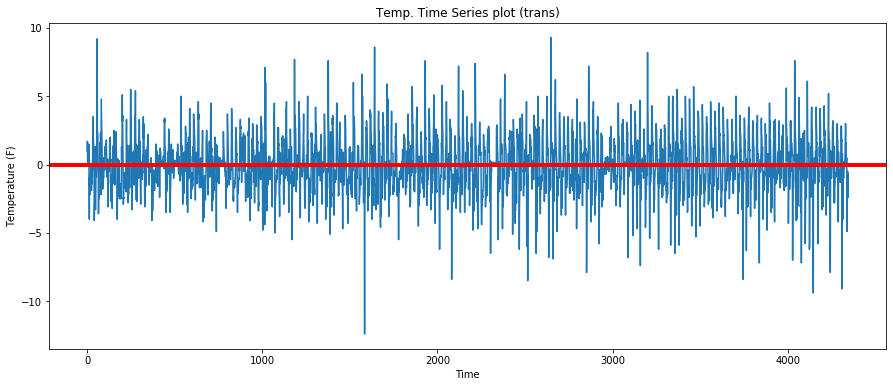

In [41]:
data['diff'] = data['Temperature'] - data['Temperature'].shift(1)
plot_timeseries(data['diff'], 'Temp. Time Series plot (trans)')

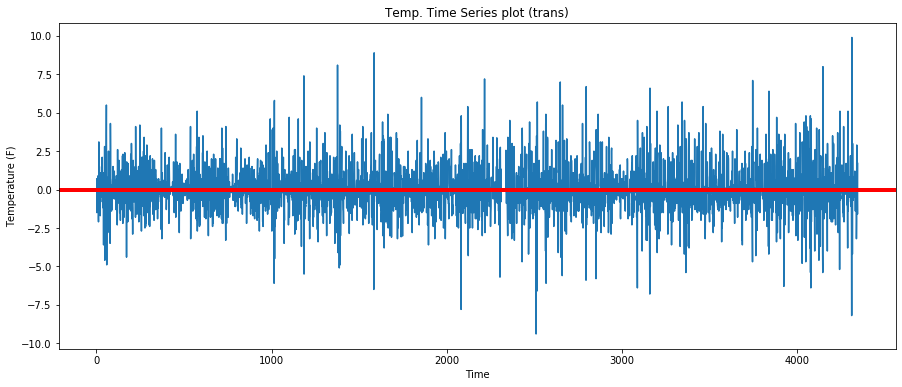

In [43]:
data['diff2'] = data['diff'] - data['diff'].shift(1)
plot_timeseries(data['diff2'], 'Temp. Time Series plot (trans)')

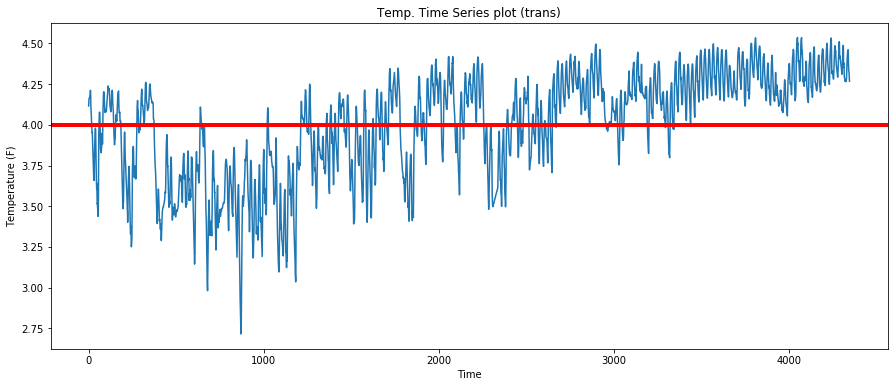

In [38]:
data['log'] = np.log(data['Temperature'])
plot_timeseries(data['log'], 'Temp. Time Series plot (trans)')

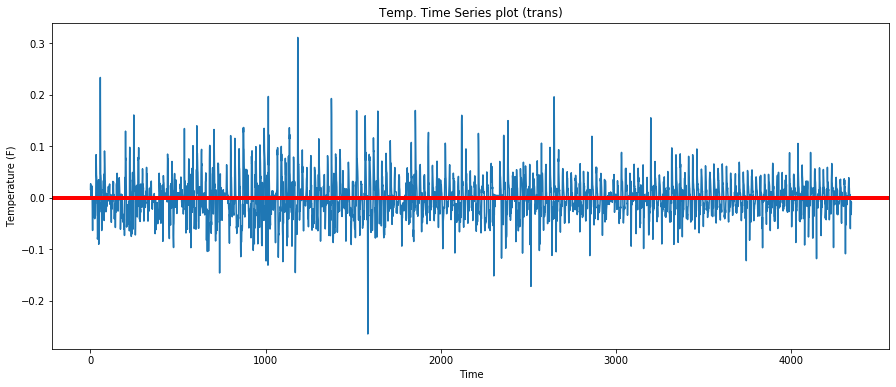

In [39]:
data['log_diff'] = data['log'] - data['log'].shift(1)
plot_timeseries(data['log_diff'], 'Temp. Time Series plot (trans)')

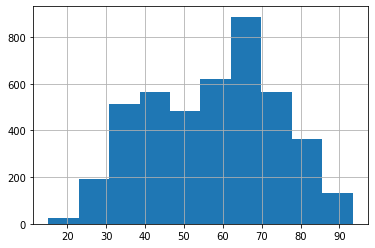

In [34]:
data['Temperature'].hist()

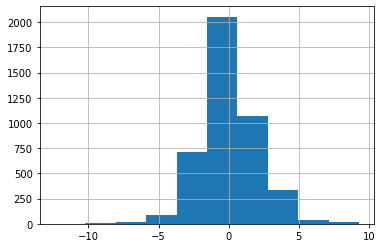

In [42]:
data['diff'].hist()

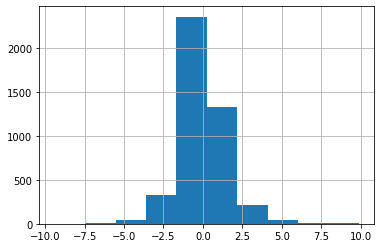

In [44]:
data['diff2'].hist()

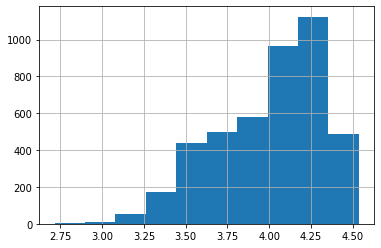

In [35]:
data['log'].hist()

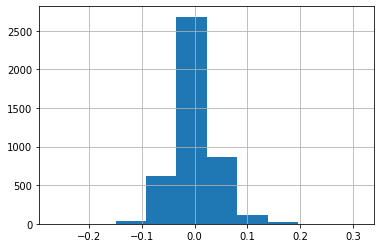

In [36]:
data['log_diff'].hist()

### Test the data if stationary
Eventhough the plot not show a obvious trend, we can run Augmented Dickey-Fuller test, which is a statistical method to testify if the time seris is stationary.
* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [5]:
def Augmented_DickeyFuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

Augmented_DickeyFuller_test(trans_data)

ADF Statistic: -4.194491
p-value: 0.000673
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Running the temperature data prints the test statistic value of -4. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.449 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure

## Task 2. Fit a simple moving average model (using the training set)

In [6]:
def data_split(data):
    rows = len(data.index)
    train = data[:int(rows*0.7)].reset_index().drop(columns=['index']).iloc[:,0]
    test = data[int(rows*0.7)+1:].reset_index().drop(columns=['index']).iloc[:,0]
    return train, test

train, test = data_split(trans_data)

### Task 2.1 Apply the simple moving average model to the training data set, for a given k.

In [7]:
def SMA(data, k):
    predict = data.rolling(window = k+1).mean()
    return predict

Let the size of window is M. When calculating the SMA, the first M preidcts are not valid since M-th temperature data are required for the first moving average data point. As the result, when we calcualte the error, we only consider the data after M-th data.

### Task 2.2 Calculate the error, i.e., the difference between the predicted and original value in the training data set, and compute the root mean squared error (RMSE).
### Task 2.3 Repeat the above two steps by varying k and calculate the RMSE.

In [8]:
def RMSE(actual, predict):
    return np.sqrt(mean_squared_error(actual, predict))
max_k = 100
windows = [i for i in range(1, max_k)]
sma_rmse = []

for k in windows:
    actual = train[k:]
    predict = SMA(train, k)[k:]
    sma_rmse.append(RMSE(actual, predict))


### Task 2.4 Plot RMSE vs k. Select k based on the lowest RMSE value. For the best value of k plot the predicted values against the original values.

Minumum RMSE value is 0.021129338585416366, when k = 1


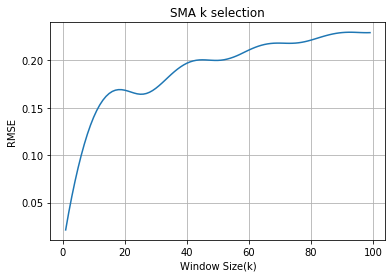

In [9]:
# Plot RMSE vs k.
plt.plot(windows, sma_rmse)
plt.grid()
plt.xlabel('Window Size(k)')
plt.ylabel('RMSE')
plt.title('SMA k selection')

print('Minumum RMSE value is {}, when k = {}'.format(min(sma_rmse), windows[sma_rmse.index(min(sma_rmse))]))

In [10]:
def plot_org_vs_est(org, est, model, param):
    # Plot Original vs Predict
    fig, ax = plt.subplots(figsize=(15,6))
    ax.plot(org, marker='.', label='Original')
    ax.plot(est, marker='*', label='Estimate')
    ax.legend()
    ax.set_ylabel('Temperature (F)')
    ax.set_xlabel('Time')
    ax.set_title('{} {} Original vs Estimate'.format(model, param))
    fig.savefig('{} {} Original vs Estimate.png'.format(model, param))

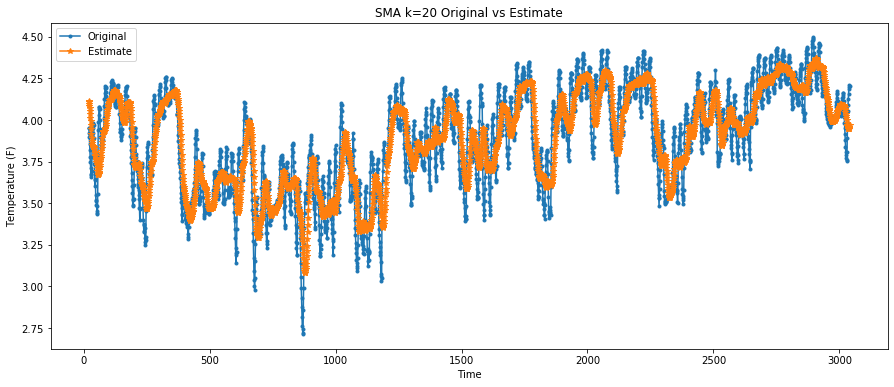

In [11]:
# Knee point
k = 20
actual = train[k:]
predict = SMA(train, k)[k:]
plot_org_vs_est(actual, predict, 'SMA', 'k=20')

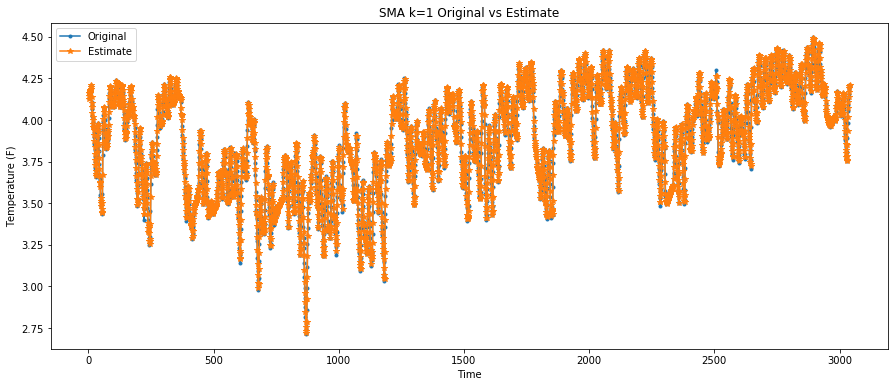

In [12]:
k = 1
actual = train[k:]
predict = SMA(train, k)[k:]
# Plot Original vs Predict
plot_org_vs_est(actual, predict, 'SMA', 'k=1')

## Task 3. Fit an exponential smoothing model (use the training set)

### Task3.1 Apply the exponential smoothing mode to the training data set for α =0.1.

In [13]:
def EMA(data, alpha=0.1):
    predict = [0] * len(data)
    predict[0] = data[0]
    for i in range(1,len(data)):
        predict[i] = alpha * data[i-1] + (1-alpha) * predict[i-1]
    return predict

### Task3.2 Calculate the error, i.e., the difference between the predicted and original value in the training data set, and compute the root mean squared error (RMSE).

### Task 3.3 Repeat steps 2.1 and 2.2 by increasing a each time by 0.1, until a = 0.9.

In [14]:
ema_rmse = []
alpha = [i/10 for i in range(1,10)]
for a in alpha:
    predict = EMA(train,a)
    ema_rmse.append(RMSE(train, predict))

### Task 3.4 Plot RMSE vs a. Select a based on the lowest RMSE value.

Minumum RMSE value is 0.04568233646721514, when alpha = 0.9


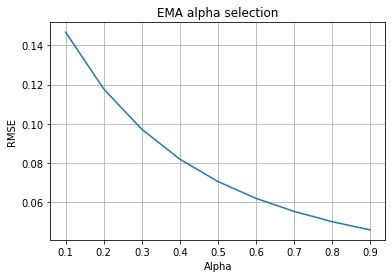

In [15]:
# Plot RMSE vs k.
plt.plot(alpha, ema_rmse)
plt.grid()
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('EMA alpha selection')

print('Minumum RMSE value is {}, when alpha = {}'.format(min(ema_rmse), alpha[ema_rmse.index(min(ema_rmse))] ))

### Task 3.5 For the selected value of a plot the predicted values against the original values, and visually inspect the accuracy of the forecasting model.

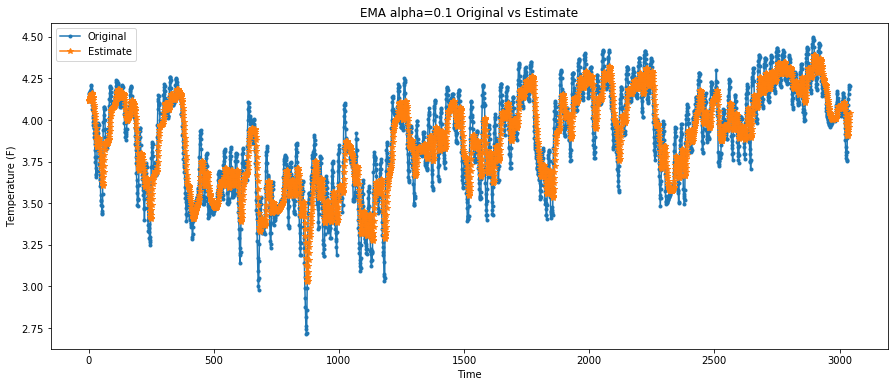

In [16]:
alpha = 0.1
actual = train.copy()
predict = EMA(train,alpha)
plot_org_vs_est(actual, predict, 'EMA', 'alpha=0.1')

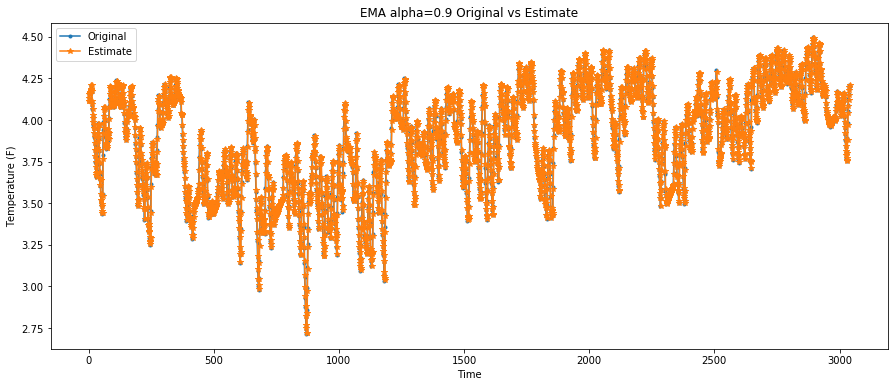

In [17]:
alpha = 0.9
actual = train.copy()
predict = EMA(train,alpha)
plot_org_vs_est(actual, predict, 'EMA', 'alpha=0.9')

## Task 4. Fit an AR(p) model (use the training set)

### Task 4.1 First select the order p of the AR model by plotting PACF in order to determine the lag k at which PACF cuts off, as discussed in section 6.4.4.

p value using PACF is 3


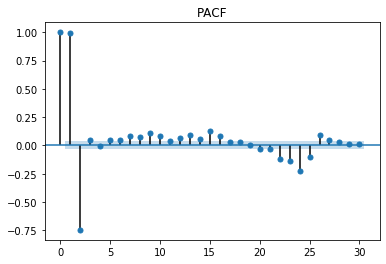

In [18]:
plot_pacf(train,lags=30, title='PACF')

delta = 0.15
lag_pacf = pacf(train, nlags=30, method='yw')
upperInt = 1.96/np.sqrt(len(train))
intPoint = -1

for i in range(0,len(lag_pacf)):
    if abs(lag_pacf[i]-upperInt) <= delta:
        print("p value using PACF is " + str(i))
        p = i
        break

### Task 4.2 Estimate the parameters of the AR(p) model. Provide RMSE value and a plot the predicted values against the original values.

In [20]:
AR = ARIMA(train, order=(p, 0, 0)) 
AR_fit = AR.fit()
print(AR_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    log   No. Observations:                 3041
Model:                     ARMA(3, 0)   Log Likelihood                6523.739
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 03 Nov 2019   AIC                         -13037.478
Time:                        22:11:04   BIC                         -13007.378
Sample:                             0   HQIC                        -13026.658
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8883      0.032    122.306      0.000       3.826       3.951
ar.L1.log      1.7526      0.018     96.759      0.000       1.717       1.788
ar.L2.log     -0.8075      0.034    -24.086      0.0

In [21]:
AR_fit.resid.describe()

count    3041.000000
mean        0.000039
std         0.028596
min        -0.177390
25%        -0.012911
50%        -0.000376
75%         0.011019
max         0.285519
dtype: float64

In [22]:
AR_fit.params

const        3.888334
ar.L1.log    1.752646
ar.L2.log   -0.807511
ar.L3.log    0.038809
dtype: float64

In [23]:
ar_residuals = train - AR_fit.fittedvalues
ar_residuals.describe()

count    3041.000000
mean        0.000039
std         0.028596
min        -0.177390
25%        -0.012911
50%        -0.000376
75%         0.011019
max         0.285519
dtype: float64

In [24]:
AR_fit.fittedvalues.describe()

count    3041.000000
mean        3.885805
std         0.304021
min         2.708992
25%         3.665224
50%         3.924489
75%         4.128648
max         4.490195
dtype: float64

RSME of AR model with train data: 0.028591347296862888


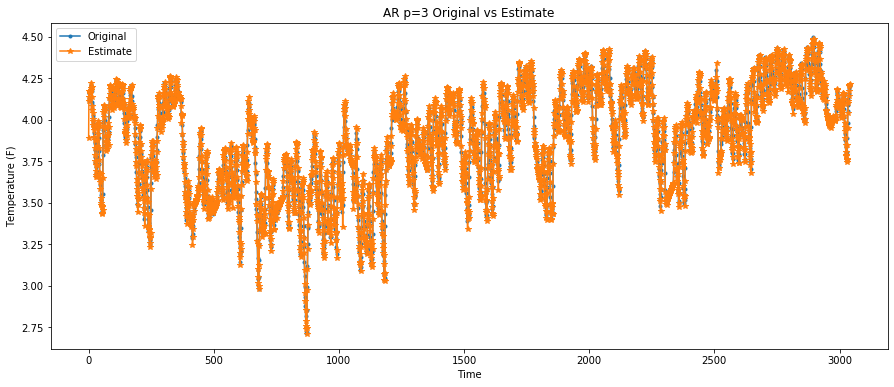

In [25]:
AR_RMSE = np.sqrt(np.mean(AR_fit.resid ** 2))
print('RSME of AR model with train data: {}'.format(AR_RMSE))
predict = AR_fit.fittedvalues
actual = train.copy()
plot_org_vs_est(actual, predict, 'AR', 'p={}'.format(p))

### Task 4.3 Carry out a residual analysis to verify the validity of the model.
a. Do a Q-Q plot of the pdf of the residuals against N(0, s2) In addition, draw the residuals histogram and carry out a χ2 test that it follows the normal distribution N(0, s2).

b. Do a scatter plot of the residuals to see if there are any correlation trends.

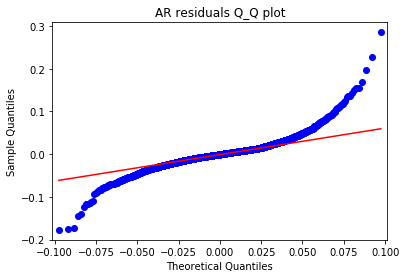


Running chisquare test.........
We have p-value is 2.300614652090682e-176
Significant Result, the null hypothesis rejected


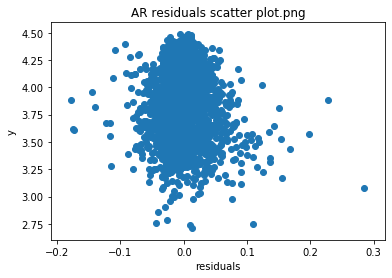

In [26]:
def plot_qqplot(error, title):
    sm.qqplot(error,loc=0,scale=np.sqrt(np.var(error)),line='q')
    plt.title('{} Q_Q plot'.format(title))
    plt.savefig('{} Q_Q plot.png'.format(title))
    plt.show()

def chisquare_test(x):
    print ("\nRunning chisquare test.........")
    k2, p = stats.normaltest(x)
    alpha = 0.05
    print('We have p-value is {}'.format(p))
    
    if p > alpha:
        print("Not Significant Result, failed to reject the null hypothesis")
    else:
        print("Significant Result, the null hypothesis rejected")

def plot_scatter(error, y_predict, title):
    plt.scatter(error,y_predict)
    plt.xlabel('residuals')
    plt.ylabel('y')
    plt.title('{} scatter plot.png'.format(title))
    plt.savefig('{} scatter plot.png'.format(title))
    plt.show()

# Residuals analysis
plot_qqplot(ar_residuals, 'AR residuals')
chisquare_test(ar_residuals)
plot_scatter(ar_residuals, AR_fit.fittedvalues, 'AR residuals')

## Task 5. Comparison of all the models (use the testing set)

RSME of SMA model with test data: 0.015068503431487195


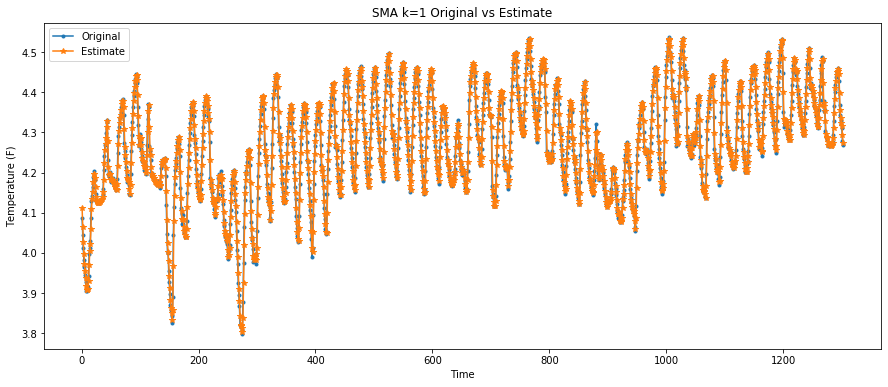

In [27]:
k = 1
actual = test[k:]
predict = SMA(test, k)[k:]
# Plot Original vs Predict
plot_org_vs_est(actual, predict, 'SMA', 'k={}'.format(k))
SMA_RMSE = RMSE(actual, predict)
print('RSME of SMA model with test data: {}'.format(SMA_RMSE))

RSME of EM model with test data: 0.032512157130479516


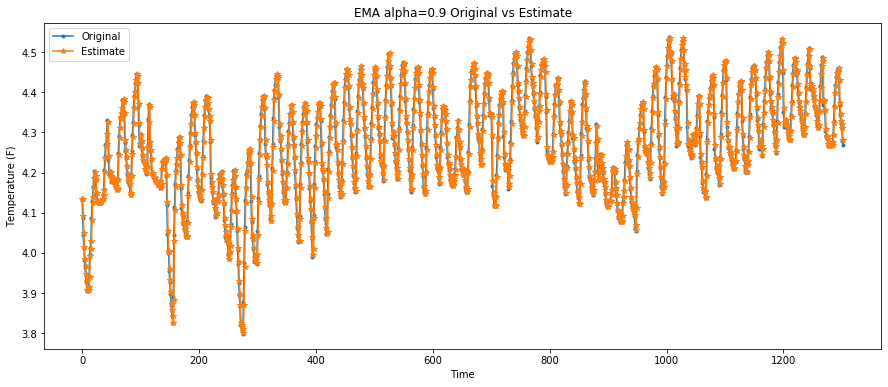

In [28]:
alpha = 0.9
actual = test.copy()
predict = EMA(test,alpha)
plot_org_vs_est(actual, predict, 'EMA', 'alpha={}'.format(alpha))
EM_RMSE = RMSE(actual, predict)
print('RSME of EM model with test data: {}'.format(EM_RMSE))

RSME of AR model with test data: 0.02057037329203222


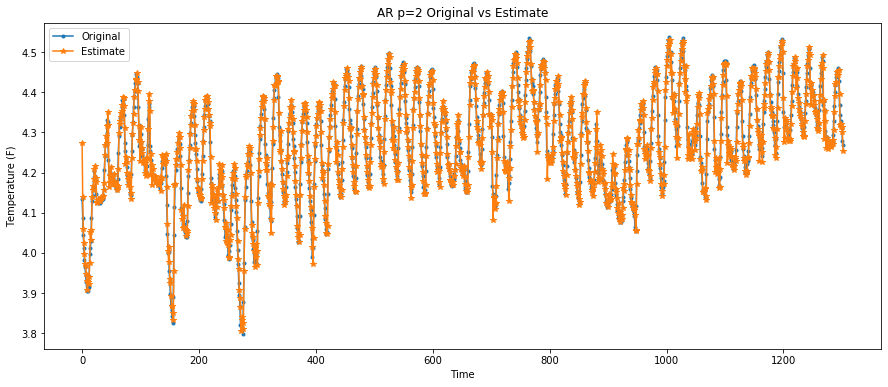

In [29]:
p = 2
AR = ARIMA(test, order=(p, 0, 0)) 
AR_fit = AR.fit()
AR_RMSE = np.sqrt(np.mean(AR_fit.resid ** 2))
print('RSME of AR model with test data: {}'.format(AR_RMSE))
predict = AR_fit.fittedvalues
actual = test.copy()
plot_org_vs_est(actual, predict, 'AR', 'p={}'.format(p))